In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meanatallahnabawy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 677MB/s]


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
train_data_dir = '/content/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [6]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [7]:
test_data_dir = '/content/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [8]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis=1)

In [9]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [10]:
classes = sorted(list(set(labels)))

In [11]:
class_weights = compute_class_weight('balanced', classes=np.array(classes), y=train_df['labels'].values)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Adjust to number of classes

# Define full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks correctly
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
callbacks = [early_stopping, reduce_lr]

# Fit the model using both callbacks
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.2591 - loss: 1.6547 - val_accuracy: 0.5057 - val_loss: 1.3114 - learning_rate: 1.0000e-04
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3130 - loss: 1.4185 - val_accuracy: 0.5591 - val_loss: 1.2336 - learning_rate: 1.0000e-04
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3833 - loss: 1.3187 - val_accuracy: 0.5809 - val_loss: 1.1641 - learning_rate: 1.0000e-04
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4453 - loss: 1.2438 - val_accuracy: 0.6649 - val_loss: 1.0941 - learning_rate: 1.0000e-04
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4975 - loss: 1.1826 - val_accuracy: 0.7157 - val_loss: 1.0374 - learning_rate: 1.0000e-04
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5561 - loss: 1.1264 - val_accuracy: 0.7078 - val_loss: 0.9920 - learning_rate: 1.0000e-04
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5909 - loss

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
# Freeze all layers except the last two convolutional blocks
for layer in base_model.layers[:15]:  # VGG16 has 19 layers, freeze up to block3
    layer.trainable = False

In [19]:
from keras.optimizers import Adam


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

callbacks = [early_stopping, reduce_lr]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6650 - loss: 0.9462 - val_accuracy: 0.7542 - val_loss: 0.8149 - learning_rate: 1.0000e-04
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6706 - loss: 0.9196 - val_accuracy: 0.7480 - val_loss: 0.8000 - learning_rate: 1.0000e-04
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6663 - loss: 0.9086 - val_accuracy: 0.7594 - val_loss: 0.7698 - learning_rate: 1.0000e-04
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6727 - loss: 0.9003 - val_accuracy: 0.7655 - val_loss: 0.7498 - learning_rate: 1.0000e-04
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6768 - loss: 0.8883 - val_accuracy: 0.7655 - val_loss: 0.7423 - learning_rate: 1.0000e-04
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6771 - loss: 0.8694 - val_accuracy: 0.7550 - val_loss: 0.7200 - learning_rate: 1.0000e-04
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6857 - loss:

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 964ms/step - accuracy: 0.6307 - loss: 0.9046
Test Accuracy: 0.7071


In [21]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred_classes, target_names=classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step
              precision    recall  f1-score   support

      glioma       0.77      0.64      0.70       300
  meningioma       0.59      0.38      0.46       306
     notumor       0.79      0.91      0.85       405
   pituitary       0.63      0.84      0.72       300

    accuracy                           0.71      1311
   macro avg       0.69      0.69      0.68      1311
weighted avg       0.70      0.71      0.69      1311



21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step
              precision    recall  f1-score   support

      glioma       0.77      0.64      0.70       300
  meningioma       0.59      0.38      0.46       306
     notumor       0.79      0.91      0.85       405
   pituitary       0.63      0.84      0.72       300

    accuracy                           0.71      1311
   macro avg       0.69      0.69      0.68      1311
weighted avg       0.70      0.71      0.69      1311



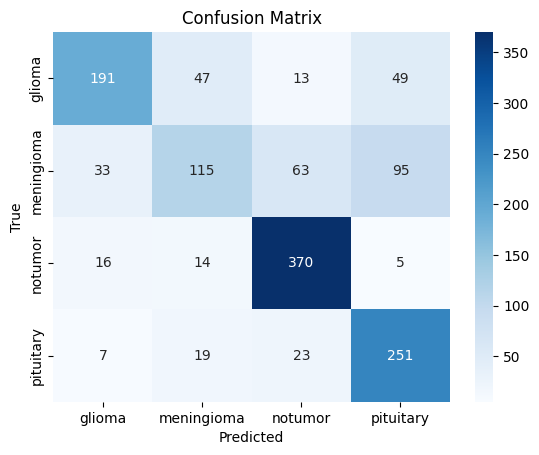

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
